In [1]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
HTML("<style>.container { width: 80% !important; }</style>")
%matplotlib inline
warnings.simplefilter('ignore')
N_JOBS = 18
SEED = 420
FOLDS = 10
SHIFT = 5

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Definitions for ML models

def fit_lasso(X_train, y_train, seed = SEED, verbose = False) :
    la = LassoCV(
        alphas = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06], 
        n_jobs = N_JOBS, 
        random_state = seed, 
        #tol = 0.0005,
        max_iter = 50000, 
        normalize  = True)
    la.fit(X_train, y_train)
    
    alpha = la.alpha_
    la = LassoCV(
        alphas = [alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                  alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3], 
        n_jobs = N_JOBS, 
        random_state = seed, 
        #tol = 0.0005,
        max_iter = 50000, 
        normalize  = True)
    la.fit(X_train, y_train)
    if (verbose) :
        print("LASSO Best alpha :", la.alpha_)
        print("LASSO iter :", la.n_iter_)

    return (la)


def fit_extra_trees(X_train, y_train, seed = SEED, verbose = False) :
    et = ExtraTreesRegressor(
        n_estimators = 300,
        criterion = "mse", 
        max_features = 0.6,
        max_depth = 6,
        min_samples_split = 10,
        min_samples_leaf = 10, 
        #bootstrap = True, 
        n_jobs = N_JOBS,
        random_state = seed)
    et.fit(X_train, y_train)                           

    return (et)


def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return("r2", r2_score(labels, preds))


def fit_xgboost(X_train, y_train, seed = SEED, verbose = True) :    
    y_mean = np.mean(y_train)
    xg_params = {
        "eta" : 0.004,
        "max_depth" : 3,
        "min_child_weight" : 2,
        "subsample" : 1.0,
        "colsample_bytree" : 0.8,
        "colsample_bylevel" : 0.6,
        "nthread" : N_JOBS, 
        "base_score" : y_mean,
        "eval_metric" : "rmse",
        "objective" : "reg:linear",
    }
    
    # XGBoost needs a validation set to find best iteration
    X_testVal = X_train.sample(frac = (1 / FOLDS), random_state = seed)
    X_trainVal = X_train.drop(X_testVal.index, axis = 0)
    X_testVal_y = y_train.sample(frac = (1 / FOLDS), random_state = seed)
    X_trainVal_y = y_train.drop(X_testVal_y.index, axis = 0)

    # Find best iteration
    xg_trainVal = xgb.DMatrix(X_trainVal, label = X_trainVal_y)
    xg_testVal = xgb.DMatrix(X_testVal, label = X_testVal_y)   
    watchlist = [(xg_trainVal, "train"), (xg_testVal, "eval")]        
    xg = xgb.train(
        params = xg_params,
        dtrain = xg_trainVal,
        evals = watchlist, 
        num_boost_round = 100000,
        early_stopping_rounds = 100,
        feval = xgb_r2_score, 
        maximize = True,
        verbose_eval = False)

    if (verbose) :
        print("XGBOOST best_iteration : " + str(xg.best_iteration))
        print("XGBOOST best_iteration adjusted : " + str(int(xg.best_iteration * (1 + (1 / FOLDS)))))
    best_iteration = int(xg.best_iteration * (1 + (1 / FOLDS)))
    #best_iteration = xg.best_iteration
    
    # Now fit on whole train set with (approximated) best iteration
    xg_train = xgb.DMatrix(X_train, label = y_train)
    xg = xgb.train(
        params = xg_params, 
        dtrain = xg_train, 
        num_boost_round = best_iteration,
        #num_boost_round = 1250,
        feval = xgb_r2_score, 
        verbose_eval = False)
    
    return (xg)

In [3]:
def fit_predict(model, X_train, y_train, X_test, seed = SEED) :
    # Fit
    if(model == "la") :
        predictor = fit_lasso(X_train, y_train.y, seed = seed)
    elif(model == "et") :
        predictor = fit_extra_trees(X_train, y_train.y, seed = seed)
    elif(model == "xg") :
        predictor = fit_xgboost(X_train, y_train.y, seed = seed, verbose = True)

    # Predict
    if (model == "xg") :
        xg_test = xgb.DMatrix(X_test)
        preds_X_test = predictor.predict(xg_test)
    else :
        preds_X_test = predictor.predict(X_test)
    
    return(preds_X_test)


def get_cv_score(model, X_train, X_train_y) :
    oof_preds = pd.DataFrame()
    oof_targets = pd.DataFrame()
    kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        print("---------")
        print("FOLD " + str(i + 1))
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = X_train_y.iloc[train_index], X_train_y.iloc[test_index]
        
        # Fit and predict
        preds_X_test_fold = fit_predict(model, X_train_fold, y_train_fold, X_test_fold, seed = (SEED * i))

        # Assemble OOF predictions
        oof_preds = pd.concat([pd.Series(oof_preds), pd.Series(preds_X_test_fold)], axis = 0)
        oof_targets = pd.concat([pd.Series(oof_targets), pd.Series(y_test_fold.y)], axis = 0)
        
    # Compute error on concatenated OOF predictions
    cv_score = r2_score(oof_targets, oof_preds)
    #cv_score = r2_score(np.exp(oof_targets) - SHIFT, np.exp(oof_preds) - SHIFT)
    print("***** Global OOF r2_score : " + str(cv_score) + " *****")
                    
    return(cv_score, oof_targets, oof_preds)

<b>Script</b>

In [4]:
# Get data
train = pd.read_csv("clean_data/train.csv")
y = pd.read_csv("clean_data/y.csv")
display(train.shape)

X_train = pd.read_csv("clean_data/X_train.csv")
X_train_y = pd.read_csv("clean_data/X_train_y.csv")
display(X_train.shape)

X_test = pd.read_csv("clean_data/X_test.csv")
X_test_y = pd.read_csv("clean_data/X_test_y.csv")
display(X_test.shape)

test = pd.read_csv("clean_data/test.csv")
test_ids = pd.read_csv("clean_data/test_ids.csv", header = None)
display(test.shape)

(4209, 437)

(3367, 437)

(842, 437)

(4209, 437)

In [7]:
model = "xg"

# Get CV score
cv_score, oof_targets, oof_preds = get_cv_score(model, train, y)

---------
FOLD 1
XGBOOST best_iteration : 829
XGBOOST best_iteration adjusted : 911
---------
FOLD 2
XGBOOST best_iteration : 794
XGBOOST best_iteration adjusted : 873
---------
FOLD 3
XGBOOST best_iteration : 1388
XGBOOST best_iteration adjusted : 1526
---------
FOLD 4
XGBOOST best_iteration : 1043
XGBOOST best_iteration adjusted : 1147
---------
FOLD 5
XGBOOST best_iteration : 1804
XGBOOST best_iteration adjusted : 1984
---------
FOLD 6
XGBOOST best_iteration : 938
XGBOOST best_iteration adjusted : 1031
---------
FOLD 7
XGBOOST best_iteration : 742
XGBOOST best_iteration adjusted : 816
---------
FOLD 8
XGBOOST best_iteration : 733
XGBOOST best_iteration adjusted : 806
---------
FOLD 9
XGBOOST best_iteration : 972
XGBOOST best_iteration adjusted : 1069
---------
FOLD 10
XGBOOST best_iteration : 807
XGBOOST best_iteration adjusted : 887
***** Global OOF r2_score : 0.56750766042 *****


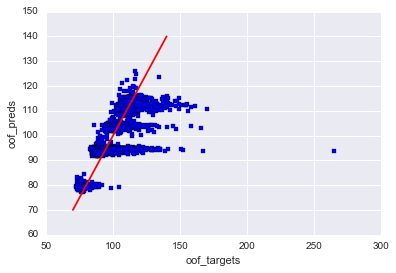

In [8]:
# Plot predictions
plt.scatter(oof_targets, oof_preds, c = "blue", marker = "s")
plt.xlabel("oof_targets")
plt.ylabel("oof_preds")
plt.plot([70, 140], [70, 140], c = "red")
plt.show()

In [6]:
'''# Save OOF preds for ensembling
preds_X_test = fit_predict(model, X_train, X_train_y, X_test)
pd.Series(preds_X_test).to_csv("preds/" + model + "_preds_X_test.csv", index = False)'''

# Predict test set
preds_test = fit_predict(model, train, y, test)
pd.DataFrame({"ID": test_ids[0], "y": preds_test}).to_csv("preds/" + model + "_preds_test.csv", index = False) 

XGBOOST best_iteration : 1806
XGBOOST best_iteration adjusted : 1986
